Epoch 1/30
1756/1756 ━━━━━━━━━━━━━━━━━━━━ 51s 27ms/step - loss: 0.0257 - val_loss: 5.5943e-04
Epoch 2/30
1756/1756 ━━━━━━━━━━━━━━━━━━━━ 52s 30ms/step - loss: 9.3708e-04 - val_loss: 4.4929e-04
Epoch 3/30
1756/1756 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - loss: 7.7955e-04 - val_loss: 4.4142e-04
Epoch 4/30
1756/1756 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - loss: 7.1427e-04 - val_loss: 3.7907e-04
Epoch 5/30
1756/1756 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: 6.1958e-04 - val_loss: 3.9419e-04
Epoch 6/30
1756/1756 ━━━━━━━━━━━━━━━━━━━━ 43s 25ms/step - loss: 6.1430e-04 - val_loss: 3.4751e-04
Epoch 7/30
1756/1756 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - loss: 5.4497e-04 - val_loss: 3.1493e-04
Epoch 8/30
1756/1756 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - loss: 5.0569e-04 - val_loss: 3.0016e-04
Epoch 9/30
1756/1756 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - loss: 5.1964e-04 - val_loss: 2.8590e-04
Epoch 10/30
1756/1756 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - loss: 4.8388e-04 - val_loss: 3.1389e-04
Epoch 11/30
1756/1756 ━

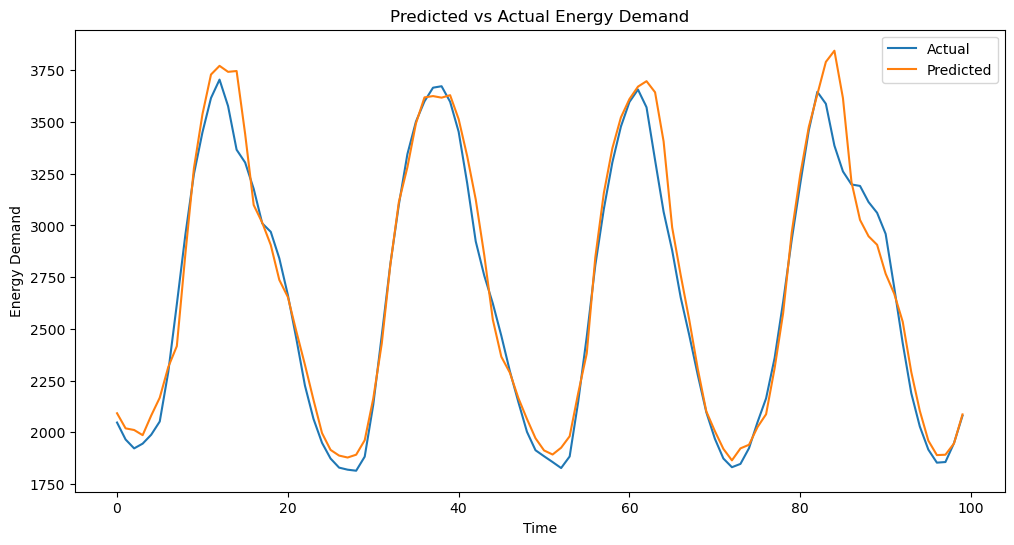

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv1D, Activation, SpatialDropout1D, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf


df = pd.read_csv('../City-Specific Data/Tampa.csv')
df.dropna(inplace=True)


df['Hour'] = pd.to_datetime(df['time']).dt.hour
df['DayOfWeek'] = pd.to_datetime(df['time']).dt.dayofweek
df['Month'] = pd.to_datetime(df['time']).dt.month
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

for lag in range(1, 25):
    df[f'Lag_{lag}'] = df['D'].shift(lag)


df['Temp_RollingMean_24'] = df['Temperature'].rolling(window=24).mean()
df['Temp_RollingStd_24'] = df['Temperature'].rolling(window=24).std()


df['Temp_Humidity_Interaction'] = df['Temperature'] * df['RelativeHumidity']


df.dropna(inplace=True)

features = df[['Temperature', 'DewPoint', 'RelativeHumidity', 'Precipitation', 'WindSpeed', 'Pressure',
               'Hour', 'DayOfWeek', 'Month', 'IsWeekend',
               'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9', 'Lag_10',
               'Lag_11', 'Lag_12', 'Lag_13', 'Lag_14', 'Lag_15', 'Lag_16', 'Lag_17', 'Lag_18', 'Lag_19',
               'Lag_20', 'Lag_21', 'Lag_22', 'Lag_23', 'Lag_24',
               'Temp_RollingMean_24', 'Temp_RollingStd_24',
               'Temp_Humidity_Interaction']].values
energy_demand = df['D'].values.reshape(-1, 1)
dates = df['time'].values


scaler_features = MinMaxScaler()
scaler_energy = MinMaxScaler()
features_normalized = scaler_features.fit_transform(features)
energy_demand_normalized = scaler_energy.fit_transform(energy_demand)

def create_sequences(data, target, dates, seq_length):
    sequences = []
    targets = []
    sequence_dates = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target_seq = target[i+seq_length]
        date_seq = dates[i+seq_length]
        sequences.append(seq)
        targets.append(target_seq)
        sequence_dates.append(date_seq)
    return np.array(sequences), np.array(targets), np.array(sequence_dates)

seq_length = 24
X, y, dates_seq = create_sequences(features_normalized, energy_demand_normalized, dates, seq_length)

def residual_block(x, dilation_rate, nb_filters, kernel_size, dropout_rate=0.2):
    prev_x = x
    x = Conv1D(filters=nb_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding='causal')(x)
    x = Activation('relu')(x)
    x = SpatialDropout1D(dropout_rate)(x)
    x = Conv1D(filters=nb_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding='causal')(x)
    x = Activation('relu')(x)
    x = SpatialDropout1D(dropout_rate)(x)


    if prev_x.shape[-1] != x.shape[-1]:
        prev_x = Conv1D(filters=nb_filters, kernel_size=1, padding='same')(prev_x)

    x = tf.keras.layers.add([prev_x, x])
    return x

def create_model(input_shape, nb_filters, kernel_size, dilations, nb_stacks):
    input_layer = Input(shape=input_shape)
    x = input_layer
    for _ in range(nb_stacks):
        for dilation_rate in dilations:
            x = residual_block(x, dilation_rate, nb_filters, kernel_size)
    x = Lambda(lambda tt: tt[:, -1, :])(x)
    output_layer = Dense(1)(x)
    model = tf.keras.models.Model(input_layer, output_layer)
    return model

kf = KFold(n_splits=5, shuffle=False, random_state=None)
mse_scores = []
mae_scores = []
mape_scores = []

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

result_df = pd.DataFrame()

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    dates_test = dates_seq[test_index]

    model = create_model(
        input_shape=(seq_length, X.shape[2]),
        nb_filters=64,
        kernel_size=2,
        dilations=[1, 2, 4, 8, 16, 32],
        nb_stacks=1
    )

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)


    predictions_normalized = model.predict(X_test)
    predictions = scaler_energy.inverse_transform(predictions_normalized)
    y_test_original = scaler_energy.inverse_transform(y_test)


    mse = mean_squared_error(y_test_original, predictions)
    mae = mean_absolute_error(y_test_original, predictions)
    mape = mean_absolute_percentage_error(y_test_original, predictions)

    mse_scores.append(mse)
    mae_scores.append(mae)
    mape_scores.append(mape)

    fold_results = pd.DataFrame({
        'Date': dates_test,
        'Actual': y_test_original.flatten(),
        'Predicted': predictions.flatten()
    })
    result_df = pd.concat([result_df, fold_results], ignore_index=True)


average_mse = np.mean(mse_scores)
average_mae = np.mean(mae_scores)
average_mape = np.mean(mape_scores)
print(f"Average Mean Squared Error: {average_mse}")
print(f"Average Mean Absolute Error: {average_mae}")
print(f"Average Mean Absolute Percentage Error: {average_mape}")


plt.figure(figsize=(12, 6))
plt.plot(result_df['Actual'][:100], label='Actual')
plt.plot(result_df['Predicted'][:100], label='Predicted')
plt.title('Predicted vs Actual Energy Demand')
plt.xlabel('Time')
plt.ylabel('Energy Demand')
plt.legend()
plt.show()